In [1]:
import numpy as np
import pytz
import datetime
import json
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
# import nltk
# nltk.download('sentiwordnet')
# from nltk.corpus import sentiwordnet as swn
# from nltk.corpus import wordnet as wn
# from nltk.tag import pos_tag
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# lemmatizer = WordNetLemmatizer()

PST_TZ = pytz.timezone('America/Los_Angeles')

GOHAWKS = "tweet_data/tweets_#gohawks.txt"
GOPATRIOTS = "tweet_data/tweets_#gopatriots.txt"
NFL = "tweet_data/tweets_#nfl.txt"
PATRIOTS = "tweet_data/tweets_#patriots.txt"
SB49 = "tweet_data/tweets_#sb49.txt"
SUPERBOWL = "tweet_data/tweets_#superbowl.txt"
ALL_FILES = [GOHAWKS, GOPATRIOTS, NFL, PATRIOTS, SB49, SUPERBOWL]
ALL_HASHTAGS = ["#gohawks", "#gopatriots", "#nfl", "#patriots", "#sb49", "#superbowl"]

In [2]:
# def GetJSONData(filepath):
#     with open(filepath, encoding="utf8") as fp:
#         data = [json.loads(line) for line in fp]
#     return data

def GetSampleJSON(filepath):
    with open(filepath, encoding="utf8") as fp:
        for line in fp:
            data = json.loads(line)
            break
    return data
    
def GetTweetStats(filepath):
    followers = 0
    retweets = 0
    data_len = 0
    count = 1
    res = []
    first_tweet = True
    with open(filepath, encoding="utf8") as fp:
        for line in fp:
            tweet = json.loads(line)
            followers += tweet['author']['followers']
            retweets += tweet['metrics']['citations']['total']
            data_len += 1
            if first_tweet:
                first_time = tweet['firstpost_date']
                first_datetime = datetime.datetime.fromtimestamp(first_time)
                next_time = first_datetime + datetime.timedelta(hours=1)
                first_tweet = False
            else:
                last_time = tweet['firstpost_date']
                last_datetime = datetime.datetime.fromtimestamp(last_time)
                if last_datetime > next_time:
                    while last_datetime >= next_time:
                        next_time = next_time + datetime.timedelta(hours=1)
                        res.append(count)
                        count = 0
                    count = 1
                else:
                    count += 1
    
    res.append(count)
    followers /= float(data_len)
    retweets /= float(data_len)
    
    time_diff = last_datetime - first_datetime
    num_hours = divmod(time_diff.total_seconds(), 3600)[0]
    tweets_per_hour = float(data_len) / num_hours
    
    return tweets_per_hour, followers, retweets, res

In [3]:
sample_data = GetSampleJSON(GOHAWKS)
print(json.dumps(sample_data, indent=2))

{
  "firstpost_date": 1419804875,
  "title": "I &lt;3 our defense! #GoHawks http://t.co/U1pcXpEsR8",
  "url": "http://twitter.com/Mich_Fit/status/549327579782840320",
  "tweet": {
    "contributors": null,
    "truncated": false,
    "text": "I &lt;3 our defense! #GoHawks http://t.co/U1pcXpEsR8",
    "in_reply_to_status_id": null,
    "id": 549327579782840320,
    "favorite_count": 1,
    "source": "<a href=\"http://twitter.com\" rel=\"nofollow\">Twitter Web Client</a>",
    "retweeted": false,
    "coordinates": null,
    "entities": {
      "symbols": [],
      "media": [
        {
          "expanded_url": "http://twitter.com/Mich_Fit/status/549327579782840320/photo/1",
          "sizes": {
            "large": {
              "h": 511,
              "resize": "fit",
              "w": 511
            },
            "small": {
              "h": 340,
              "resize": "fit",
              "w": 340
            },
            "medium": {
              "h": 511,
              "re

In [48]:
nfl_counts = []
superbowl_counts = []
for file, hashtag in zip(ALL_FILES, ALL_HASHTAGS):
    stats = GetTweetStats(file)
    print("Statisics for", hashtag)
    print("Average tweets per hour:", stats[0])
    print("Average followers per tweet:", stats[1])
    print("Average retweets per tweet:", stats[2])
    print()
    if hashtag == "nfl":
        nfl_counts = stats[3]
    elif hashtag == "superbowl":
        superbowl_counts = stats[3]

Statisics for gohawks
Average tweets per hour: 173.99382716049382
Average followers per tweet: 2217.9237355281984
Average retweets per tweet: 2.0132093991319877
Statisics for gopatriots
Average tweets per hour: 34.42313323572474
Average followers per tweet: 1427.2526051635405
Average retweets per tweet: 1.4081919101697078
Statisics for nfl
Average tweets per hour: 251.64362850971924
Average followers per tweet: 4662.37544523693
Average retweets per tweet: 1.5344602655543254
Statisics for patriots
Average tweets per hour: 449.61326530612246
Average followers per tweet: 3280.4635616550277
Average retweets per tweet: 1.7852871288476946
Statisics for sb49
Average tweets per hour: 1277.7474226804125
Average followers per tweet: 10374.160292019487
Average retweets per tweet: 2.52713444111402
Statisics for superbowl
Average tweets per hour: 1268.3521421107628
Average followers per tweet: 8814.96799424623
Average retweets per tweet: 2.3911895819207736


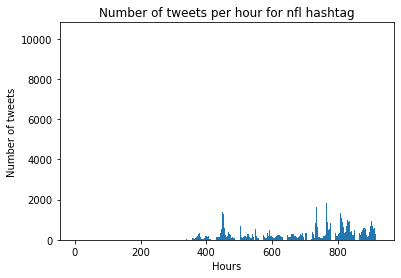

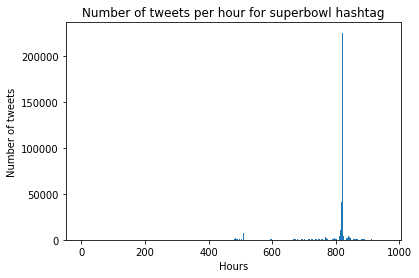

In [49]:
plt.bar(range(len(nfl_counts)), nfl_counts)
plt.title("Number of tweets per hour for nfl hashtag")
plt.xlabel("Hours")
plt.ylabel("Number of tweets")
plt.show()
plt.bar(range(len(superbowl_counts)), superbowl_counts)
plt.title("Number of tweets per hour for superbowl hashtag")
plt.xlabel("Hours")
plt.ylabel("Number of tweets")
plt.show()

In [19]:
happy_emoticons = [":)", ":-)", ":’)", ":]", "=]"]
sad_emoticons = [":(", ":-(", ":’(", ":[", "=["]
basic_feature_len = 5
total_feature_len = 16

def UpdateFeatureHistory(tweet, history):
    hashtags = [t for t in tweet['title'].split() if t.startswith('#')]
    for h in hashtags:
        if h.lower() == history['hashtags'][0] and h not in history['hashtags']:
            history['hashtags'].append(h)
            
    if 'unique_author_count' not in history:
        history['unique_author_count'] = 0
        history['authors'] = set()
        
    nameid = tweet['author']['name'] + tweet['author']['nick']
    if nameid not in history['authors']:
        history['authors'].add(nameid)
        history['unique_author_count'] += 1
        
    tokens = nltk.tokenize.word_tokenize(tweet['title'])
    stop = stopwords.words('english')
    
#     if 'pos_score' not in history:
#         history['pos_score'] = 0.0
#         history['neg_score'] = 0.0
    
#     pos_map = {"N" : 'n', "V" : 'v', "J" : 'a', "R" : 'r'}
#     text = []
#     for word in tokens:
#         if word not in stop and word[0] != '#' and not word.startswith("http"):
#             text.append(word)
#     text = pos_tag(text)
#     for word, pos in text:
#         c = pos[0]
#         if c not in pos_map:
#             continue
            
#         lemma = lemmatizer.lemmatize(word, pos=pos_map[c])
#         if not lemma:
#             continue
            
#         synsets = wn.synsets(word, pos=pos_map[c])
#         if not synsets:
#             continue

#         sent = swn.senti_synset(synsets[0].name())
#         history['pos_score'] += sent.pos_score()
#         history['neg_score'] += sent.neg_score()
    
    return history
        
def UpdateFeature(feature, tweet, cur_datetime, history={}):
    feature[0] += 1 # number of tweets in window
    feature[1] += tweet['metrics']['citations']['total'] # number of retweets
    feature[2] += tweet['author']['followers'] # number of followers
    feature[3] = max(feature[3], tweet['author']['followers']) # max number of followers per post
    feature[4] = cur_datetime.hour # hour of the day
    if len(feature) == total_feature_len:
        history = UpdateFeatureHistory(tweet, history)
        feature[5] += tweet['title'].count('@') # mention count
        feature[6] += 1 if tweet['title'].count("http") > 0 else 0 # url count
        feature[7] += (0 if all([tweet['title'].count(emote) == 0 for emote in happy_emoticons]) else 1) # tweets with happy emote
        feature[8] += (0 if all([tweet['title'].count(emote) == 0 for emote in sad_emoticons]) else 1) # tweets with sad emote
        feature[9] += tweet['title'].count("#") - 1 # number of additional hashtags
        feature[10] = len(history['hashtags'][0]) # length of hashtag
        feature[11] = len(history['hashtags']) # number of case-sensitive variations
        feature[12] = history['unique_author_count'] # unique number of authors
#         feature[16] = history['pos_score'] # positive sentiment score
#         feature[17] = history['neg_score'] # negative sentiment score
    return feature, history

def FinalizeFeature(feature):
    if len(feature) == total_feature_len and feature[0] != 0:
        feature[6] /= float(feature[0]) # change url count to url ratio
        feature[13] = float(feature[1]) / feature[0] # add retweet ratio
        feature[14] = float(feature[5]) / feature[0] # add mention ratio
        feature[15] = float(feature[12]) / feature[0] # add unique author ratio
#         feature[16] /= float(feature[0]) # avg pos score
#         feature[17] /= float(feature[0]) # avg neg score
    return feature
    
def GetDataTargets(data):
    targets = []
    for idx in range(len(data)-1):
        targets.append(data[idx+1][0])
    targets.append(0)
    return targets
    
def GetDataFeatures(filepath, hashtag="", piece_wise=False):
    td = datetime.timedelta(hours=1)
    data = []
    boundarys = []
    feature_len = basic_feature_len if hashtag == "" else total_feature_len
    history = {}
    history['hashtags'] = [hashtag]
    cur_feature = np.zeros(feature_len)
    first_tweet = True
    with open(filepath, encoding="utf8") as fp:
        for line in fp:
            tweet = json.loads(line)
            cur_time = tweet['firstpost_date']
            cur_datetime = datetime.datetime.fromtimestamp(cur_time, PST_TZ)
            if first_tweet:
                end_time = cur_datetime.replace(second=0, microsecond=0, minute=0) + td
                cur_feature, history = UpdateFeature(cur_feature, tweet, cur_datetime, history)
                first_tweet = False
            else:
                if cur_datetime < end_time:
                    cur_feature, history = UpdateFeature(cur_feature, tweet, cur_datetime, history)
                else:
                    while cur_datetime >= end_time:
                        end_time += td
                        data.append(FinalizeFeature(cur_feature))
                        cur_feature = np.zeros(feature_len)
                        history = {}
                        history['hashtags'] = [hashtag]
                        if piece_wise:
                            if end_time.month == 2 and end_time.day == 1 and end_time.hour == 8 and end_time.minute == 0:
                                td = datetime.timedelta(minutes=5)
                                boundarys.append(len(data))
                            elif end_time.month == 2 and end_time.day == 1 and end_time.hour == 20 and end_time.minute == 0:
                                td = datetime.timedelta(hours=1)
                                boundarys.append(len(data))
                    cur_feature, history = UpdateFeature(cur_feature, tweet, cur_datetime, history)
    data.append(cur_feature)
    targets = GetDataTargets(data)
    data = np.array(data)
    targets = np.array(targets)
    if piece_wise:
        data = [data[:boundarys[0]], data[boundarys[0]+1:boundarys[1]], data[boundarys[1]+1:]]
        targets = [targets[:boundarys[0]], targets[boundarys[0]+1:boundarys[1]], targets[boundarys[1]+1:]]
    return data, targets

In [5]:
def ScoreOLS(data, targets, verbose=True, return_model=False):
    data = sm.add_constant(data)
    model = sm.OLS(targets, data)
    results = model.fit()
    
    preds = results.predict(data)
    mse = mean_squared_error(targets, preds)
    r2 = r2_score(targets, preds)

    if verbose:
        print("mse:", mse)
        print("r2:", r2)
        print("tvalues:", results.tvalues)
        print("pvalues:", results.pvalues)
    if return_model:
        return results

In [13]:
for file, hashtag in zip(ALL_FILES, ALL_HASHTAGS):
    data, targets = GetDataFeatures(file)
    print("Results for", hashtag)
    print("data shape:", data.shape)
    ScoreOLS(data, targets)
    print()

Results for #gohawks
data shape: (973, 5)
mse: 453578.7486139947
r2: 0.48590927617552493
tvalues: [ 1.08077764 10.44064355 -4.07835853 -2.9768586   0.65304     1.37735108]
pvalues: [2.80065503e-01 2.97508596e-24 4.90865442e-05 2.98474171e-03
 5.13885719e-01 1.68722443e-01]

Results for #gopatriots
data shape: (684, 5)
mse: 21831.47522865118
r2: 0.653971081911064
tvalues: [ 0.17076797 -1.59989195  8.02088091 -3.604888    2.54022053 -0.18773757]
pvalues: [8.64457165e-01 1.10088401e-01 4.61673254e-15 3.35183637e-04
 1.13002596e-02 8.51138550e-01]

Results for #nfl
data shape: (927, 5)
mse: 173049.88794530474
r2: 0.6014683557318541
tvalues: [ 2.01563501  5.58944403 -3.53909633  4.94821016 -3.34897774  2.39503814]
pvalues: [4.41281846e-02 3.00072288e-08 4.21575799e-04 8.90288019e-07
 8.44009171e-04 1.68175348e-02]

Results for #patriots
data shape: (981, 5)
mse: 2786511.109114322
r2: 0.7080068674117341
tvalues: [  1.05038766  21.65141621 -12.11920832   6.65463573  -1.31312292
   1.00209429]

In [12]:
gohawks_data, gohawks_targets = GetDataFeatures(GOHAWKS, "#gohawks")
print("Results for #gohawks")
print("data shape:", gohawks_data.shape)
ScoreOLS(gohawks_data, gohawks_targets)

Results for #gohawks
data shape: (973, 16)
mse: 330299.90750283125
r2: 0.6256347568175098
tvalues: [ 7.25701319e-03 -4.03389902e+00 -2.38422264e+00 -3.92733025e+00
  1.95517417e+00 -6.77233034e-01 -4.89324029e-01 -1.01206166e-01
 -2.90423550e+00  9.54651216e+00  8.01078294e+00 -8.38225671e-01
  2.37625906e+00  2.23330478e+00  8.60169803e-01 -4.33989395e-01
  2.88460358e-01]
pvalues: [9.94211306e-01 5.92341486e-05 1.73094625e-02 9.20651955e-05
 5.08535727e-02 4.98421956e-01 6.24724560e-01 9.19408023e-01
 3.76626186e-03 1.08277541e-20 3.30070260e-15 4.02113494e-01
 1.76853261e-02 2.57595847e-02 3.89911104e-01 6.64394064e-01
 7.73056902e-01]


In [33]:
gopatriots_data, gopatriots_targets = GetDataFeatures(GOPATRIOTS, "#gopatriots")
print("Results for #gopatriots")
print("data shape:", gopatriots_data.shape)
ScoreOLS(gopatriots_data, gopatriots_targets)

Results for #gopatriots
data shape: (684, 18)
mse: 6414.296422747241
r2: 0.8983333912061017
tvalues: [  0.08784632  -2.46621358   1.51075398   9.90387978 -11.31988459
  -0.18808352  19.67954535  -0.88117472 -19.80214376   2.86026487
   8.04941149  -2.66399184   0.79633656 -11.36704566  -0.91213191
  -4.05047451   3.16429464  -0.21511103  -0.33683247]
pvalues: [9.30025271e-01 1.39061690e-02 1.31326154e-01 1.15849688e-21
 2.73711213e-27 8.50868556e-01 2.72409831e-68 3.78541620e-01
 5.89958449e-69 4.36566930e-03 3.83752910e-15 7.90906485e-03
 4.26120629e-01 1.74236626e-27 3.62029820e-01 5.71425317e-05
 1.62547474e-03 8.29746707e-01 7.36349465e-01]


In [34]:
nfl_data, nfl_targets = GetDataFeatures(NFL, "#nfl")
print("Results for #nfl")
print("data shape:", nfl_data.shape)
ScoreOLS(nfl_data, nfl_targets)

Results for #nfl
data shape: (927, 18)
mse: 96213.79716977153
r2: 0.7784208747972708
tvalues: [ 1.80060958e-02  8.12458659e+00  4.70975104e-01 -2.46947130e+00
  2.45272544e+00 -2.05661657e+00  4.95550346e+00 -1.69494813e+00
  3.98578565e+00  2.31444637e+00  1.26811413e+01 -2.47057432e+00
  1.46529536e+00 -1.97467513e+01 -1.51287087e+00 -1.09601273e+00
  6.35245143e+00  4.85068618e-01 -3.50889085e-02]
pvalues: [9.85637946e-01 1.45992108e-15 6.37771639e-01 1.37142684e-02
 1.43650200e-02 4.00083925e-02 8.60469033e-07 9.04281316e-02
 7.26536485e-05 2.08655841e-02 4.80078281e-34 1.36723347e-02
 1.43186522e-01 1.72610174e-72 1.30660427e-01 2.73363811e-01
 3.34678861e-10 6.27744676e-01 9.72016558e-01]


In [35]:
patriots_data, patriots_targets = GetDataFeatures(PATRIOTS, "#patriots")
print("Results for #patriots")
print("data shape:", patriots_data.shape)
ScoreOLS(patriots_data, patriots_targets)

Results for #patriots
data shape: (981, 18)
mse: 2218948.451675396
r2: 0.7674806652170433
tvalues: [ 2.12157769e-03 -8.43371872e-01  2.71389411e+00  9.31100611e+00
 -6.63290878e+00  2.89262024e-01  4.38874744e+00 -1.06334352e+00
 -5.88737628e+00  1.57639578e-01  1.76841422e+00  1.96721841e+00
 -3.66529716e+00 -8.97368171e-01 -1.13630807e+00  1.35343742e+00
  9.15263893e-02 -2.85325387e-02 -1.04115053e+00]
pvalues: [9.98307667e-01 3.99230147e-01 6.76864229e-03 8.34993639e-20
 5.48284547e-11 7.72443196e-01 1.26610900e-05 2.87893040e-01
 5.41647801e-09 8.74773896e-01 7.73085590e-02 4.94450567e-02
 2.60562339e-04 3.69747009e-01 2.56110641e-01 1.76233851e-01
 9.27093393e-01 9.77243334e-01 2.98067278e-01]


In [36]:
sb49_data, sb49_targets = GetDataFeatures(SB49, "#sb49")
print("Results for #sb49")
print("data shape:", sb49_data.shape)
ScoreOLS(sb49_data, sb49_targets)

Results for #sb49
data shape: (583, 18)
mse: 11775554.483453885
r2: 0.8576444719770125
tvalues: [ 2.11303005e-03 -1.95387328e+00  4.21792513e+00  5.62388600e-02
  1.14235129e+00 -6.02995873e-01  1.00200336e+01  5.45682882e-01
  9.18142382e+00 -2.98716300e+00  5.17861155e+00 -3.81506310e-01
 -3.20331028e-01 -4.84193999e+00 -2.40451782e+00  1.02025332e+00
  4.30318276e-01  2.89334359e-01 -7.21307146e-01]
pvalues: [9.98314794e-01 5.12100915e-02 2.87220569e-05 9.55171441e-01
 2.53792746e-01 5.46753826e-01 7.37226506e-22 5.85499692e-01
 8.02119800e-19 2.93819417e-03 3.11540815e-07 7.02971272e-01
 7.48836046e-01 1.66276744e-06 1.65151551e-02 3.08045763e-01
 6.67128515e-01 7.72431846e-01 4.71019456e-01]


In [37]:
superbowl_data, superbowl_targets = GetDataFeatures(SUPERBOWL, "#superbowl")
print("Results for #superbowl")
print("data shape:", superbowl_data.shape)
ScoreOLS(superbowl_data, superbowl_targets)

Results for #superbowl
data shape: (959, 18)
mse: 22579062.770048738
r2: 0.8590487884791304
tvalues: [ 2.11301082e-04  6.55154532e+00 -2.00169005e+00 -8.30155175e+00
  7.10644520e+00 -1.33348557e+00 -3.28540515e+00  2.50700124e-01
  2.04393919e+00 -7.22989352e+00  1.23862364e+01 -1.81841439e-01
 -3.63931086e+00 -8.73231901e+00  3.42498326e-01  4.18012591e-01
  1.03978014e+00 -9.62710525e-01 -6.64918172e-02]
pvalues: [9.99831451e-01 9.36672475e-11 4.56050687e-02 3.55007709e-16
 2.35236446e-12 1.82695548e-01 1.05601562e-03 8.02100751e-01
 4.12378158e-02 1.00067187e-12 9.53549658e-33 8.55746367e-01
 2.88263353e-04 1.12530422e-17 7.32052472e-01 6.76033382e-01
 2.98709424e-01 3.35940396e-01 9.47000411e-01]


In [6]:
all_measures = ["number of tweets", "number of retweets", "number of followers", "max number of followers", 
               "hour of the day", "mention count", "url ratio", "happy emote count", "sad emote count",
               "number of extra hashtags", "length of hashtag", "number of case-sensitive variations", "unique author count",
               "retweet ratio", "mention ratio", "author ratio", "positive sentiment score", "negative sentiment score"]

def PlotPValues(data, target, model, hashtag):
    pvalues = model.pvalues
    inds = np.argsort(pvalues)[:3] - 1
    for i in range(3):
        print("pvalue:", pvalues[inds[i]+1])
        print("coefficient:", model.params[inds[i]+1])
        plt.scatter(data[:, inds[i]], target)
        plt.title("{} vs target for {}".format(all_measures[inds[i]], hashtag))
        plt.xlabel(all_measures[inds[i]])
        plt.ylabel("Number of tweets in next hour")
        plt.show()

pvalue: 1.0827754083575446e-20
coefficient: 340.2934075970108


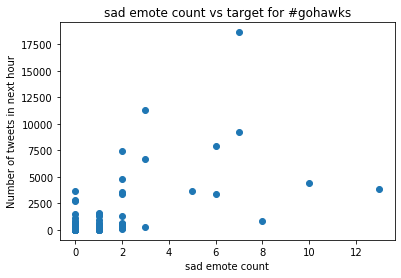

pvalue: 3.3007026004198587e-15
coefficient: 1.6084167459350227


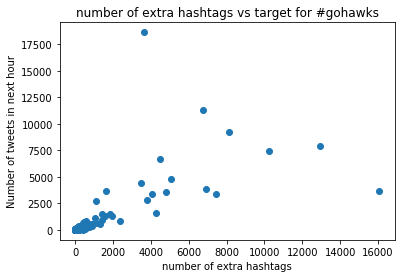

pvalue: 5.9234148567636725e-05
coefficient: -1.3479651169105749


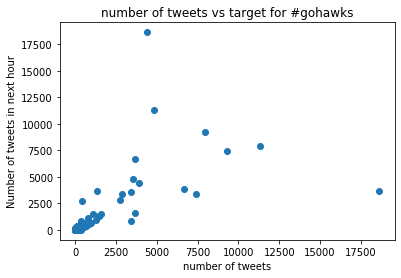

In [14]:
model = ScoreOLS(gohawks_data, gohawks_targets, verbose=False, return_model=True)
PlotPValues(gohawks_data, gohawks_targets, model, "#gohawks")

pvalue: 5.899584487226542e-69


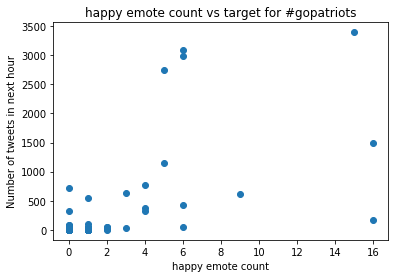

pvalue: 2.7240983130124113e-68


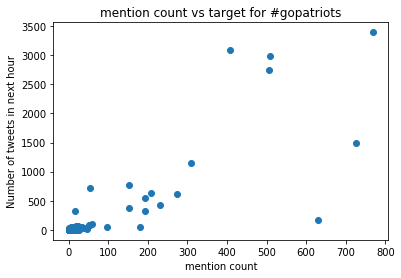

pvalue: 1.742366256720484e-27


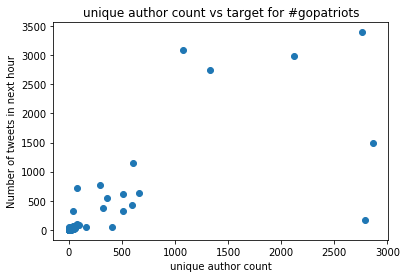

In [55]:
model = ScoreOLS(gopatriots_data, gopatriots_targets, verbose=False, return_model=True)
PlotPValues(gopatriots_data, gopatriots_targets, model, "#gopatriots")

pvalue: 1.726101739858267e-72


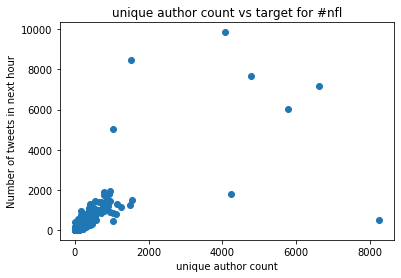

pvalue: 4.800782809303105e-34


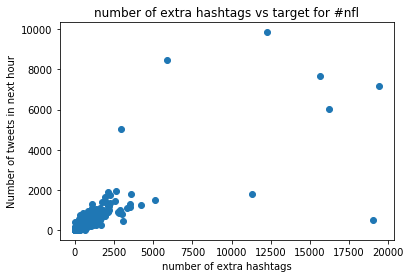

pvalue: 1.4599210809436532e-15


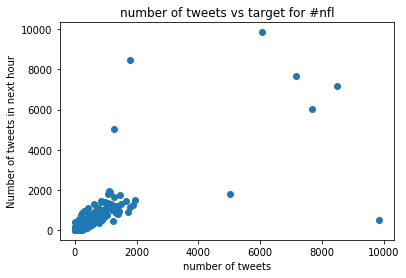

In [56]:
model = ScoreOLS(nfl_data, nfl_targets, verbose=False, return_model=True)
PlotPValues(nfl_data, nfl_targets, model, "#nfl")

pvalue: 8.349936390825665e-20


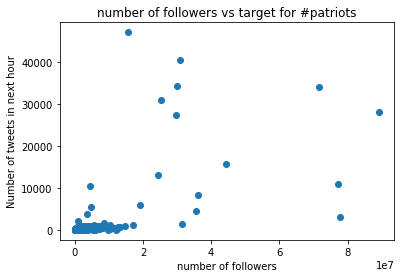

pvalue: 5.4828454729990625e-11


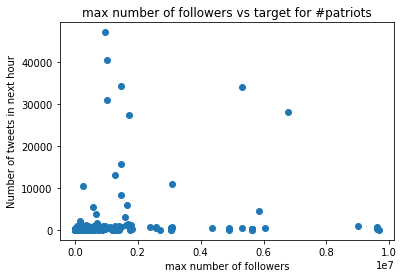

pvalue: 5.416478009380215e-09


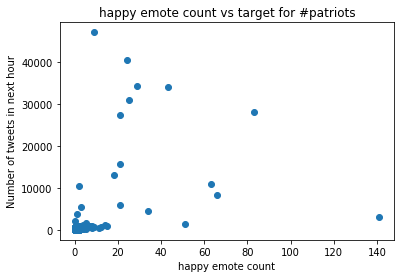

In [57]:
model = ScoreOLS(patriots_data, patriots_targets, verbose=False, return_model=True)
PlotPValues(patriots_data, patriots_targets, model, "#patriots")

pvalue: 7.372265061250514e-22


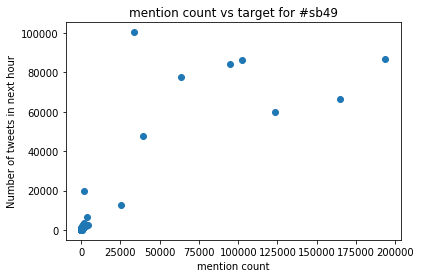

pvalue: 8.021197996398474e-19


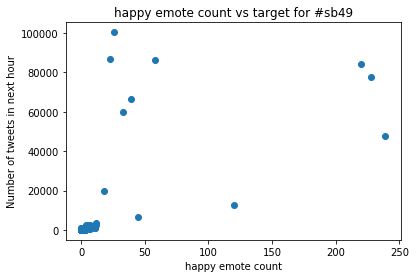

pvalue: 3.11540815292195e-07


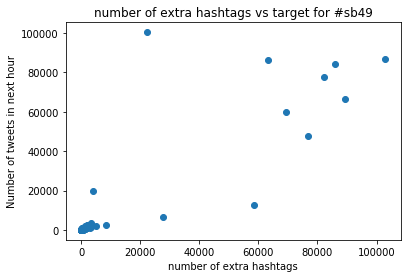

In [58]:
model = ScoreOLS(sb49_data, sb49_targets, verbose=False, return_model=True)
PlotPValues(sb49_data, sb49_targets, model, "#sb49")

pvalue: 9.535496582008746e-33


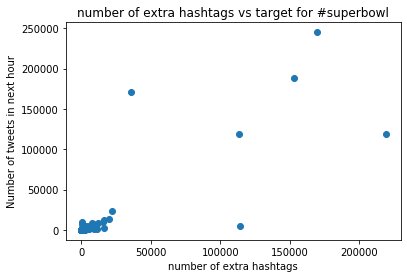

pvalue: 1.1253042199390676e-17


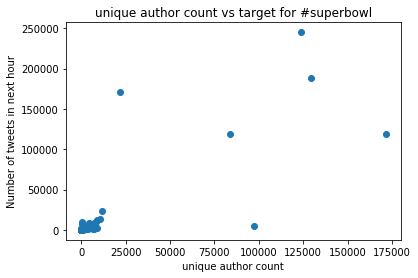

pvalue: 3.550077092820716e-16


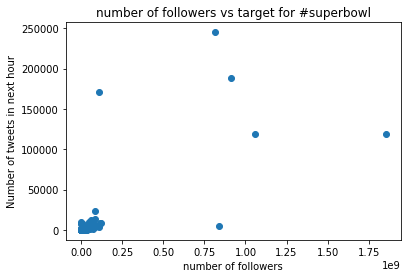

In [59]:
model = ScoreOLS(superbowl_data, superbowl_targets, verbose=False, return_model=True)
PlotPValues(superbowl_data, superbowl_targets, model, "#superbowl")

In [106]:
import copy

def GetPieceWiseOLS(datafile, hashtag):
    datap, targetsp = GetDataFeatures(datafile, hashtag, piece_wise=True)
    print("Results for", hashtag)
    for i in range(3):
        print("Time interval:", i+1)
        print("data shape:", datap[i].shape)
        ScoreOLS(datap[i], targetsp[i])
        print()
    return datap, targetsp

def FinalizeMergedFeatures(feature):
    if len(feature) == total_feature_len and feature[0] != 0:
        feature[6] /= float(feature[0]) # change url count to url ratio
        feature[13] = float(feature[1]) / feature[0] # add retweet ratio
        feature[14] = float(feature[5]) / feature[0] # add mention ratio
        feature[15] = float(feature[12]) / feature[0] # add unique author ratio
#         feature[16] /= float(feature[0]) # avg pos score
#         feature[17] /= float(feature[0]) # avg neg score
    return feature
        
def MergeFeatures(feature, data_sample):
    feature[0] += data_sample[0]
    feature[1] += data_sample[1]
    feature[2] += data_sample[2]
    feature[3] = max(feature[3], data_sample[3])
    feature[4] = data_sample[4]
    if len(feature) == total_feature_len:
        feature[5] += data_sample[5]
        feature[6] += data_sample[6]
        feature[7] += data_sample[7]
        feature[8] += data_sample[8]
        feature[9] += data_sample[9]
        feature[10] += data_sample[10]
        feature[11] += data_sample[11]
        feature[12] = max(feature[12], data_sample[12])
    
    return feature
        
def MergeIntervals(all_data, all_targets):
    data_res = []
    target_res = []
    for i in range(3):
        data_interval_res = []
        target_interval_res = []
        for j in range(len(all_data[0][i])):
            feature = np.zeros(len(all_data[0][0][0]))
            target = 0
            for n in range(len(all_data)):
                feature = MergeFeatures(feature, all_data[n][i][j])
                target += all_targets[n][i][j]
            data_interval_res.append(FinalizeMergedFeatures(feature))
            target_interval_res.append(target)
        data_res.append(np.array(data_interval_res))
        target_res.append(np.array(target_interval_res))
    return data_res, target_res
        
def RescaleData(data):
    for i in range(len(data)):
        if data[i, 0] != 0:
            data[i, 6] *= data[i, 0]
            data[i, 13] *= data[i, 0]
            data[i, 14] *= data[i, 0]
            data[i, 15] *= data[i, 0]
    return data

def UndoFinalization(all_data):
    for i in range(len(all_data)):
        for j in range(3):
            if len(all_data[i][j][0]) == total_feature_len:
                all_data[i][j] = RescaleData(all_data[i][j])
    return all_data

def MergePieceWiseData(all_data, all_targets):
    all_data = copy.deepcopy(all_data)
    all_targets = copy.deepcopy(all_targets)
    feature_len = len(all_data[0][0][0])
    max_interval1 = max([len(data[0]) for data in all_data])
    max_interval3 = max([len(data[2]) for data in all_data])
    all_data = UndoFinalization(all_data)
    for i in range(len(all_data)):
        l = len(all_data[i][0])
        if l < max_interval1:
            all_data[i][0] = np.vstack((np.zeros((max_interval1 - l, feature_len)), all_data[i][0]))
            all_targets[i][0] = np.hstack((np.zeros(max_interval1 - l), all_targets[i][0]))
        l = len(all_data[i][2])
        if l < max_interval3:
            all_data[i][2] = np.vstack((all_data[i][2], np.zeros((max_interval3 - l, feature_len))))
            all_targets[i][2] = np.hstack((all_targets[i][2], np.zeros(max_interval3 - l)))
    data, targets = MergeIntervals(all_data, all_targets)
    return data, targets

In [99]:
gohawks_datap, gohawks_targetsp = GetPieceWiseOLS(GOHAWKS, "#gohawks")

Results for #gohawks
Time interval: 1
data shape: (833, 16)
mse: 271375.4453824609
r2: 0.5143299935459041
tvalues: [ 6.55991015e-03 -7.19475303e+00 -7.93865099e-01 -5.15020664e-01
 -1.56462223e-01 -8.77473463e-01 -1.73629254e+00  1.22588651e+00
 -2.92701387e+00  1.56894413e+01 -7.53035422e+00  1.67308388e+00
  4.97478090e+00  9.02919953e+00  6.86840835e-01 -1.04459300e+00
 -2.86109152e+00]
pvalues: [9.94767590e-01 1.41830633e-12 4.27504762e-01 6.06678059e-01
 8.75707395e-01 3.80487795e-01 8.28895482e-02 2.20595054e-01
 3.51741455e-03 1.11181816e-48 1.34170960e-13 9.46940728e-02
 7.96759812e-07 1.22456219e-18 4.92378171e-01 2.96520465e-01
 4.32975355e-03]

Time interval: 2
data shape: (144, 16)
mse: 61254.29949735092
r2: 0.5676572445073016
tvalues: [-0.64600513 -0.26364935 -1.28808716  1.08702681  0.72270027 -1.63245084
  0.11282917  0.25802731  1.74897831  1.67657243 -0.29994562  3.21641765
  0.77793791  0.39418992 -0.46956921  0.08536386]
pvalues: [0.51943253 0.7924741  0.20003932 0.2

In [100]:
gopatriots_datap, gopatriots_targetsp = GetPieceWiseOLS(GOPATRIOTS, "#gopatriots")

Results for #gopatriots
Time interval: 1
data shape: (547, 16)
mse: 816.0768269847177
r2: 0.7536959469681632
tvalues: [  0.2590933    1.78199846  -5.41844279 -13.26683076  13.38037686
  -1.50252777   8.44576988   1.11857251  -1.8911604    4.75953724
  -4.50988442  -0.29386201   2.30478656   5.29303723   4.66259234
  -4.31339546  -1.11407542]
pvalues: [7.95663854e-01 7.53219090e-02 9.13879215e-08 6.87442003e-35
 2.19955121e-35 1.33556431e-01 2.91504112e-16 2.63829279e-01
 5.91479893e-02 2.50637248e-06 7.99216589e-06 7.68978391e-01
 2.15641030e-02 1.76457348e-07 3.95670496e-06 1.91796393e-05
 2.65751794e-01]

Time interval: 2
data shape: (144, 16)
mse: 12324.588070470398
r2: 0.5223329450133817
tvalues: [ 0.04652615  0.29934212  1.11698536 -0.14711703  0.11190717  2.06692459
 -1.17694499 -0.64436606  1.57810923  1.85705067 -1.02208771  1.01018449
  2.00193039 -0.1974338  -0.60249909 -0.72463702 -1.17839037]
pvalues: [0.96296398 0.76516834 0.26610931 0.88327294 0.91107369 0.04077291
 0.241

In [101]:
nfl_datap, nfl_targetsp = GetPieceWiseOLS(NFL, "#nfl")

Results for #nfl
Time interval: 1
data shape: (779, 16)
mse: 33315.6413326962
r2: 0.6484421163339069
tvalues: [ 0.02800562  2.8461485   0.50520066  2.54450765 -1.77792636 -0.91107432
  3.07853289 -2.9215585   5.22856027  2.6579762  -0.68903963  1.80059588
  1.15319507 -2.50527532 -1.18456502 -0.90598552  0.62414686]
pvalues: [9.77665000e-01 4.54402520e-03 6.13563993e-01 1.11394027e-02
 7.58146676e-02 3.62544330e-01 2.15483028e-03 3.58580869e-03
 2.20865689e-07 8.02593262e-03 4.91008072e-01 7.21619259e-02
 2.49191929e-01 1.24431957e-02 2.36558808e-01 3.65229895e-01
 5.32717949e-01]

Time interval: 2
data shape: (144, 16)
mse: 17780.86647313727
r2: 0.8447347821668826
tvalues: [ 0.44916821  0.19930531 -0.68607878 -0.40188168  1.25624898 -2.55289566
 -4.23759184  0.3225843  -2.57955759 -1.03160638  2.01358905 -0.2042526
  1.16509804  0.06891077  0.3668086  -1.20560849]
pvalues: [6.54069905e-01 8.42340186e-01 4.93904287e-01 6.88441346e-01
 2.11313702e-01 1.18571552e-02 4.28803343e-05 7.4753

In [102]:
patriots_datap, patriots_targetsp = GetPieceWiseOLS(PATRIOTS, "#patriots")

Results for #patriots
Time interval: 1
data shape: (833, 16)
mse: 158980.53614173605
r2: 0.6354641056037006
tvalues: [ 7.92191381e-03  5.61792280e+00  1.25242569e+00  1.13901116e+01
 -1.00556139e+01  4.35982270e-01 -7.18188136e-01 -2.95516893e+00
 -1.79024033e+00 -4.53775232e+00 -3.97084334e+00  1.32344221e+00
  1.70507333e-01 -2.50117211e+00 -1.08317647e+00 -6.58642896e-01
  4.27895932e-01]
pvalues: [9.93681230e-01 2.65159649e-08 2.10773613e-01 5.36725549e-28
 1.66412302e-22 6.62964907e-01 4.72846863e-01 3.21490451e-03
 7.37859271e-02 6.54009416e-06 7.79389954e-05 1.86059038e-01
 8.64653434e-01 1.25732298e-02 2.79050057e-01 5.10310905e-01
 6.68839794e-01]

Time interval: 2
data shape: (144, 16)
mse: 595454.6927199176
r2: 0.7470428129678642
tvalues: [-0.53868548 -1.11292538 -2.50951553  1.7219453   0.85910033 -2.47476196
 -0.89470682 -0.92651747 -1.89104251 -1.42227953  1.43207389  0.164699
  1.15966344  0.40184497  1.50736584 -1.43180032]
pvalues: [0.5910395  0.26782619 0.01333758 0.0

In [103]:
sb49_datap, sb49_targetsp = GetPieceWiseOLS(SB49, "#sb49")

Results for #sb49
Time interval: 1
data shape: (435, 16)
mse: 5552.573110082231
r2: 0.8940050125720045
tvalues: [ 0.09698118  0.68616778  3.28436123  0.73110571 -1.25497567 -2.24546249
 -5.53731217  0.37145914  0.39930809 -2.81399458 -2.19142094  1.74094128
 -1.30529714  3.80105414  0.17045785  0.75126626 -0.99196969]
pvalues: [9.22787823e-01 4.92987734e-01 1.10818187e-03 4.65124206e-01
 2.10188779e-01 2.52603577e-02 5.43741384e-08 7.10483793e-01
 6.89870140e-01 5.12404110e-03 2.89725135e-02 8.24296572e-02
 1.92509713e-01 1.65510574e-04 8.64732552e-01 4.52915178e-01
 3.21786182e-01]

Time interval: 2
data shape: (144, 16)
mse: 1108663.2170089097
r2: 0.8852080792967942
tvalues: [ 1.38245157 -0.3590673   0.42201259  0.22789143  2.56718778  2.49370218
 -1.38434168  0.92119826  0.59111349 -2.44737238  1.05737494  0.60154506
 -0.85134796  0.26388018  1.6522966  -1.14487268]
pvalues: [0.16924047 0.72013636 0.67372379 0.82009428 0.01140273 0.01391704
 0.16866256 0.35867991 0.55548679 0.015746

In [104]:
superbowl_datap, superbowl_targetsp = GetPieceWiseOLS(SUPERBOWL, "#superbowl")

Results for #superbowl
Time interval: 1
data shape: (811, 16)
mse: 239493.10602732401
r2: 0.5379453607842347
tvalues: [ 2.05046972e-03  2.32332205e-01  1.39618490e-01  1.88601108e+00
 -7.08572112e-01 -1.02778913e+00  3.38145832e+00 -5.09333383e+00
 -4.67640008e+00  4.86709141e+00  1.25379114e+00  2.76446957e-01
  5.14263118e-01 -2.71386454e-01  4.58840263e-01 -1.29170308e+00
  1.31592903e+00]
pvalues: [9.98364478e-01 8.16339871e-01 8.88996837e-01 5.96582268e-02
 4.78798020e-01 3.04362028e-01 7.56280475e-04 4.39814128e-07
 3.43032462e-06 1.36637654e-06 2.10286953e-01 7.82276737e-01
 6.07211144e-01 7.86164361e-01 6.46474453e-01 1.96835859e-01
 1.88577661e-01]

Time interval: 2
data shape: (144, 16)
mse: 3403401.6667640167
r2: 0.9447354946932396
tvalues: [ 3.12849817 -4.28424911 -0.26092117  0.71020348  1.2755984   4.74402135
 -3.64938713  1.2191714  -1.6532614  -5.75609332  0.62081485  2.15891426
 -1.15888527  1.80772431 -0.6086296  -0.27496574]
pvalues: [2.17601440e-03 3.57186044e-05 7.

In [113]:
all_datap, all_targetsp = MergePieceWiseData([gohawks_datap, gopatriots_datap, nfl_datap, patriots_datap, sb49_datap, superbowl_datap],
                                          [gohawks_targetsp, gopatriots_targetsp, nfl_targetsp, patriots_targetsp, sb49_targetsp, superbowl_targetsp])
# all_datap, all_targetsp = MergePieceWiseData([gohawks_datap, gopatriots_datap],
#                                           [gohawks_targetsp, gopatriots_targetsp])

# print(all_datap[0][:, 6])
# print(all_targetsp[0])

In [114]:
print("Aggregated data -")
for i in range(3):
    print("Interval {} data shape {}".format(i+1, all_datap[i].shape))
    print("Target shape:", all_targetsp[i].shape)
    ScoreOLS(all_datap[i], all_targetsp[i])
    print()

Aggregated data -
Interval 1 data shape (833, 16)
Target shape: (833,)
mse: 1875421.031074805
r2: 0.5771227684213784
tvalues: [ 1.04993472e-01  8.07018710e-03  3.44456925e+00 -1.34931324e+00
 -1.14942323e+00 -1.56561209e+00  2.93157435e+00 -9.87780919e-01
 -6.57325334e+00  9.92080954e+00 -6.48657407e-01 -2.52660593e+00
  3.60351360e+00  1.95014365e+00 -5.81000796e-01 -8.93439951e-02
  1.32854579e+00]
pvalues: [9.16406791e-01 9.93562965e-01 6.01149207e-04 1.77610630e-01
 2.50718287e-01 1.17827155e-01 3.46671683e-03 3.23552753e-01
 8.77542413e-11 5.58917876e-22 5.16742341e-01 1.17050699e-02
 3.32966526e-04 5.15010915e-02 5.61400349e-01 9.28830454e-01
 1.84369279e-01]

Interval 2 data shape (144, 16)
Target shape: (144,)
mse: 11242990.559371693
r2: 0.9009258776138567
tvalues: [ 0.64684263  5.53170957 -2.49850907 -0.81963172  1.00003754  2.61778881
  2.55561063 -2.50023315  1.50687979 -0.71802577 -5.56146769 -0.26386164
  1.1136029   0.43905317  0.73609574  1.01026688 -0.59147082]
pvalues: